In [14]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
#export
from utils.nb_functions import *
from utils.nb_classes_l8_to_10 import *


jump to 52:49 in Lesson 10 video


## Early stopping

### Better callback cancellation

In [16]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

In [17]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [18]:
#export
class Callback():
    _order=0
    def set_runner(self, run): 
        self.run=run
    def __getattr__(self, k): 
        #line below is equivalent to self.run.k
        return getattr(self.run, k)
    
    @property
    def name(self):
        #remove 'Callback' from name
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')
    
    def __call__(self, cb_name):
        #Return the value of the named attribute of object
        f = getattr(self, cb_name, None)
        if f and f(): 
            return True
        return False

class TrainEvalCallback(Callback):
    def begin_fit(self):
        print('>>TrainEvalCallback.begin_fit()')
        self.run.n_epochs=0.
        self.run.n_iter=0
    
    def after_batch(self):
        if not self.in_train: 
            return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter   += 1
        
    def begin_epoch(self):
        self.run.n_epochs=self.epoch
        self.model.train()
        self.run.in_train=True

    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False

class CancelTrainException(Exception): 
    pass
class CancelEpochException(Exception): 
    pass
class CancelBatchException(Exception): 
    pass

as previous Runner but added 1 line of code, the CancelTrainException

In [19]:
#export

class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        self.in_train = False
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs

    @property
    def opt(self):       
        return self.learn.opt
    @property
    def model(self):     
        return self.learn.model
    @property
    def loss_func(self): 
        return self.learn.loss_func
    @property
    def data(self):      
        return self.learn.data

    def one_batch(self, xb, yb):
        print('>>Runner.one_batch()')
        try:
            self.xb,self.yb = xb,yb
            self('begin_batch')
            self.pred = self.model(self.xb)
            self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb)
            self('after_loss')
            if not self.in_train: 
                return
            self.loss.backward()
            self('after_backward')
            self.opt.step()
            self('after_step')
            self.opt.zero_grad()
        except CancelBatchException: 
            self('after_cancel_batch')
        finally: 
            self('after_batch')

    def all_batches(self, dl):
        print('>>Runner.all_batches()')
        self.iters = len(dl)
        try:
            for xb,yb in dl: 
                self.one_batch(xb, yb)
        except CancelEpochException: 
            self('after_cancel_epoch')

    def fit(self, epochs, learn):
        self.epochs,self.learn,self.loss = epochs,learn,tensor(0.)
        try:
            for cb in self.cbs: 
                cb.set_runner(self)
            self('begin_fit')
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): 
                    self.all_batches(self.data.train_dl)
                with torch.no_grad(): 
                    if not self('begin_validate'): 
                        self.all_batches(self.data.valid_dl)
                self('after_epoch')
            
        except CancelTrainException: 
            #when we run next line we jump to __call__
            self('after_cancel_train')
            
        finally:
            self('after_fit')
            self.learn = None

    def __call__(self, cb_name):
        res = False
        for cb in sorted(self.cbs, key=lambda x: x._order): 
            res = cb(cb_name) and res
        return res

In [20]:
learn = create_learner(get_model, loss_func, data)

In [21]:
class TestCallback(Callback):
    _order=1
    def after_step(self):
        print(self.n_iter)
        if self.n_iter>=10: 
            raise CancelTrainException()

In [22]:
run = Runner(cb_funcs=TestCallback)

>>Runner.__init__(), cbs: None, cb_funcs: <class '__main__.TestCallback'>
cbs: []
cbf: <class '__main__.TestCallback'>


In [23]:
run.fit(3, learn)

>>Runner.fit()
--Runner.cbs: [<__main__.TrainEvalCallback object at 0x7f2bdb16d978>, <__main__.TestCallback object at 0x7f2bdb16dcf8>]
>>Callback.set_runner()
>>Callback.set_runner()
>>Runner.__call__() cb_name: begin_fit
--Runner.__call__ cb: <__main__.TrainEvalCallback object at 0x7f2bdb16d978> res: False
--Callback.__call__() cbname: begin_fit, type(f): <class 'method'>
>>TrainEvalCallback.begin_fit()
--Runner.__call__ cb: <__main__.TestCallback object at 0x7f2bdb16dcf8> res: False
>>Callback.__getattr__()
--Callback.__call__() cbname: begin_fit, type(f): <class 'NoneType'>
>>Runner.__call__() cb_name: begin_epoch
--Runner.__call__ cb: <__main__.TrainEvalCallback object at 0x7f2bdb16d978> res: False
--Callback.__call__() cbname: begin_epoch, type(f): <class 'method'>
>>Callback.__getattr__()
>>Callback.__getattr__()
--Runner.__call__ cb: <__main__.TestCallback object at 0x7f2bdb16dcf8> res: False
>>Callback.__getattr__()
--Callback.__call__() cbname: begin_epoch, type(f): <class 'No

### Other callbacks

In [49]:
#export
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): 
            stats.accumulate(self.run)
    
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)
        
class Recorder(Callback):
    def begin_fit(self):
        self.lrs = [[] for _ in self.opt.param_groups]
        self.losses = []

    def after_batch(self):
        if not self.in_train: 
            return
        for pg,lr in zip(self.opt.param_groups,self.lrs): lr.append(pg['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self, pgid=-1): 
        plt.plot(self.lrs[pgid])
    def plot_loss(self, skip_last=0): 
        plt.plot(self.losses[:len(self.losses)-skip_last])
        
    def plot(self, skip_last=0, pgid=-1):
        losses = [o.item() for o in self.losses]
        lrs    = self.lrs[pgid]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(lrs[:n], losses[:n])

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs): 
        self.pname,self.sched_funcs = pname,sched_funcs
        
    def begin_fit(self):
        if not isinstance(self.sched_funcs, (list,tuple)):
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)

    def set_param(self):
        assert len(self.opt.param_groups)==len(self.sched_funcs)
        for pg,f in zip(self.opt.param_groups,self.sched_funcs):
            pg[self.pname] = f(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: 
            self.set_param()

### LR Finder

NB: You may want to also add something that saves the model before running this, and loads it back after running - otherwise you'll lose your weights!

In [55]:
#export
class LR_Find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter,self.min_lr,self.max_lr = max_iter,min_lr,max_lr
        self.best_loss = 1e9
        
    def begin_batch(self): 
        if not self.in_train: 
            return
        pos = self.n_iter/self.max_iter
        print(f'--LR_Find.begin_batch() pos: {pos}')
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos
        print(f'--LR_Find.begin_batch() self.opt.param_groups: {self.opt.param_groups}')
        for pg in self.opt.param_groups: 
            pg['lr'] = lr
            
    def after_step(self):
        print(f'>>LR_Find.after_step()')
        if self.n_iter>=self.max_iter or self.loss>self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: 
            self.best_loss = self.loss

NB: In fastai we also use exponential smoothing on the loss. For that reason we check for `best_loss*3` instead of `best_loss*10`.

In [56]:
learn = create_learner(get_model, loss_func, data)

In [57]:
run = Runner(cb_funcs=[LR_Find, Recorder])

>>Runner.__init__()
cbs: []
cbf: <class '__main__.LR_Find'>
cbf: <class '__main__.Recorder'>


In [58]:
run.fit(2, learn)

>>Runner.fit()
Runner.cbs: [<__main__.TrainEvalCallback object at 0x7f21e0702240>, <__main__.LR_Find object at 0x7f21e0702f98>, <__main__.Recorder object at 0x7f21e0702f28>]
Callback.set_runner()
Callback.set_runner()
Callback.set_runner()
>>__call__() cb_name: begin_fit
__call__ cb: <__main__.TrainEvalCallback object at 0x7f21e0702240> res: False
__call__() cbname: begin_fit, type(f): <class 'method'>
TrainEvalCallback.begin_fit()
__call__ cb: <__main__.Recorder object at 0x7f21e0702f28> res: False
__call__() cbname: begin_fit, type(f): <class 'method'>
__call__ cb: <__main__.LR_Find object at 0x7f21e0702f98> res: False
__call__() cbname: begin_fit, type(f): <class 'NoneType'>
>>__call__() cb_name: begin_epoch
__call__ cb: <__main__.TrainEvalCallback object at 0x7f21e0702240> res: False
__call__() cbname: begin_epoch, type(f): <class 'method'>
__call__ cb: <__main__.Recorder object at 0x7f21e0702f28> res: False
__call__() cbname: begin_epoch, type(f): <class 'NoneType'>
__call__ cb: <

>>__call__() cb_name: after_backward
__call__ cb: <__main__.TrainEvalCallback object at 0x7f21e0702240> res: False
__call__() cbname: after_backward, type(f): <class 'NoneType'>
__call__ cb: <__main__.Recorder object at 0x7f21e0702f28> res: False
__call__() cbname: after_backward, type(f): <class 'NoneType'>
__call__ cb: <__main__.LR_Find object at 0x7f21e0702f98> res: False
__call__() cbname: after_backward, type(f): <class 'NoneType'>
>>__call__() cb_name: after_step
__call__ cb: <__main__.TrainEvalCallback object at 0x7f21e0702240> res: False
__call__() cbname: after_step, type(f): <class 'NoneType'>
__call__ cb: <__main__.Recorder object at 0x7f21e0702f28> res: False
__call__() cbname: after_step, type(f): <class 'NoneType'>
__call__ cb: <__main__.LR_Find object at 0x7f21e0702f98> res: False
__call__() cbname: after_step, type(f): <class 'method'>
>>LR_Find.after_step()
>>__call__() cb_name: after_batch
__call__ cb: <__main__.TrainEvalCallback object at 0x7f21e0702240> res: False
_

--LR_Find.begin_batch() self.opt.param_groups: [{'params': [Parameter containing:
tensor([[ 0.0257,  0.0267,  0.0355,  ...,  0.0164,  0.0093,  0.0301],
        [ 0.0070,  0.0064,  0.0081,  ...,  0.0077,  0.0269, -0.0251],
        [-0.0211, -0.0356, -0.0018,  ...,  0.0095, -0.0022,  0.0190],
        ...,
        [ 0.0330,  0.0198, -0.0257,  ..., -0.0246,  0.0219, -0.0241],
        [ 0.0040, -0.0064, -0.0277,  ..., -0.0031, -0.0142,  0.0290],
        [ 0.0311,  0.0069,  0.0329,  ..., -0.0269, -0.0007,  0.0023]],
       requires_grad=True), Parameter containing:
tensor([ 1.6801e-02,  1.8398e-02, -2.1437e-02,  3.2496e-02, -3.0270e-02,
        -1.8152e-02, -2.4957e-02, -9.8861e-03,  1.8546e-02, -1.5512e-02,
        -1.4516e-02, -5.6049e-03, -3.0154e-02,  3.1996e-02, -3.1386e-02,
        -8.3863e-03, -3.1330e-02, -1.5293e-02, -3.2640e-02, -4.3339e-03,
        -3.4023e-02,  2.7401e-02,  3.0872e-03, -1.3628e-02, -5.2129e-03,
        -6.6364e-05,  1.2293e-02,  2.4489e-02,  9.4472e-03, -3.4569e-

--LR_Find.begin_batch() self.opt.param_groups: [{'params': [Parameter containing:
tensor([[ 0.0257,  0.0267,  0.0355,  ...,  0.0164,  0.0093,  0.0301],
        [ 0.0070,  0.0064,  0.0081,  ...,  0.0077,  0.0269, -0.0251],
        [-0.0211, -0.0356, -0.0018,  ...,  0.0095, -0.0022,  0.0190],
        ...,
        [ 0.0330,  0.0198, -0.0257,  ..., -0.0246,  0.0219, -0.0241],
        [ 0.0040, -0.0064, -0.0277,  ..., -0.0031, -0.0142,  0.0290],
        [ 0.0311,  0.0069,  0.0329,  ..., -0.0269, -0.0007,  0.0023]],
       requires_grad=True), Parameter containing:
tensor([ 1.6816e-02,  1.8394e-02, -2.1432e-02,  3.2494e-02, -3.0286e-02,
        -1.8154e-02, -2.4958e-02, -9.8848e-03,  1.8548e-02, -1.5524e-02,
        -1.4515e-02, -5.6042e-03, -3.0157e-02,  3.1987e-02, -3.1380e-02,
        -8.3845e-03, -3.1326e-02, -1.5306e-02, -3.2651e-02, -4.3352e-03,
        -3.4020e-02,  2.7418e-02,  3.0860e-03, -1.3630e-02, -5.2137e-03,
        -6.6800e-05,  1.2294e-02,  2.4482e-02,  9.4461e-03, -3.4568e-

--LR_Find.begin_batch() self.opt.param_groups: [{'params': [Parameter containing:
tensor([[ 0.0257,  0.0267,  0.0355,  ...,  0.0164,  0.0093,  0.0301],
        [ 0.0070,  0.0064,  0.0081,  ...,  0.0077,  0.0269, -0.0251],
        [-0.0211, -0.0356, -0.0018,  ...,  0.0095, -0.0022,  0.0190],
        ...,
        [ 0.0330,  0.0198, -0.0257,  ..., -0.0246,  0.0219, -0.0241],
        [ 0.0040, -0.0064, -0.0277,  ..., -0.0031, -0.0142,  0.0290],
        [ 0.0311,  0.0069,  0.0329,  ..., -0.0269, -0.0007,  0.0023]],
       requires_grad=True), Parameter containing:
tensor([ 1.6935e-02,  1.8371e-02, -2.1393e-02,  3.2475e-02, -3.0437e-02,
        -1.8175e-02, -2.4952e-02, -9.8709e-03,  1.8580e-02, -1.5615e-02,
        -1.4507e-02, -5.5964e-03, -3.0185e-02,  3.1897e-02, -3.1345e-02,
        -8.3972e-03, -3.1280e-02, -1.5402e-02, -3.2756e-02, -4.3435e-03,
        -3.4002e-02,  2.7552e-02,  3.0799e-03, -1.3671e-02, -5.2199e-03,
        -5.6913e-05,  1.2308e-02,  2.4411e-02,  9.4277e-03, -3.4558e-

--LR_Find.begin_batch() self.opt.param_groups: [{'params': [Parameter containing:
tensor([[ 0.0257,  0.0267,  0.0355,  ...,  0.0164,  0.0093,  0.0301],
        [ 0.0070,  0.0064,  0.0081,  ...,  0.0077,  0.0269, -0.0251],
        [-0.0211, -0.0356, -0.0018,  ...,  0.0095, -0.0022,  0.0190],
        ...,
        [ 0.0330,  0.0198, -0.0257,  ..., -0.0246,  0.0219, -0.0241],
        [ 0.0040, -0.0064, -0.0277,  ..., -0.0031, -0.0142,  0.0290],
        [ 0.0311,  0.0069,  0.0329,  ..., -0.0269, -0.0007,  0.0023]],
       requires_grad=True), Parameter containing:
tensor([ 1.7762e-02,  1.8268e-02, -2.1113e-02,  3.2269e-02, -3.1435e-02,
        -1.8240e-02, -2.5005e-02, -9.8115e-03,  1.8912e-02, -1.6269e-02,
        -1.4366e-02, -5.5077e-03, -3.0313e-02,  3.1193e-02, -3.1097e-02,
        -8.3335e-03, -3.0881e-02, -1.6107e-02, -3.3291e-02, -4.4651e-03,
        -3.3765e-02,  2.8659e-02,  3.0730e-03, -1.3796e-02, -5.2178e-03,
         6.5767e-05,  1.2354e-02,  2.3956e-02,  9.4306e-03, -3.4287e-

--LR_Find.begin_batch() self.opt.param_groups: [{'params': [Parameter containing:
tensor([[ 0.0257,  0.0267,  0.0355,  ...,  0.0164,  0.0093,  0.0301],
        [ 0.0070,  0.0064,  0.0081,  ...,  0.0077,  0.0269, -0.0251],
        [-0.0211, -0.0356, -0.0018,  ...,  0.0095, -0.0022,  0.0190],
        ...,
        [ 0.0330,  0.0198, -0.0257,  ..., -0.0246,  0.0219, -0.0241],
        [ 0.0040, -0.0064, -0.0277,  ..., -0.0031, -0.0142,  0.0290],
        [ 0.0311,  0.0069,  0.0329,  ..., -0.0269, -0.0007,  0.0023]],
       requires_grad=True), Parameter containing:
tensor([ 0.0205,  0.0183, -0.0187,  0.0344, -0.0339, -0.0178, -0.0235, -0.0094,
         0.0225, -0.0179, -0.0121, -0.0050, -0.0304,  0.0297, -0.0276, -0.0079,
        -0.0263, -0.0173, -0.0340, -0.0047, -0.0316,  0.0347,  0.0038, -0.0145,
        -0.0051,  0.0007,  0.0128,  0.0229,  0.0097, -0.0329,  0.0128,  0.0023,
        -0.0227, -0.0347,  0.0078,  0.0113,  0.0062,  0.0184, -0.0066, -0.0183,
        -0.0132,  0.0327,  0.0280,

>>__call__() cb_name: after_batch
__call__ cb: <__main__.TrainEvalCallback object at 0x7f21e0702240> res: False
__call__() cbname: after_batch, type(f): <class 'method'>
__call__ cb: <__main__.Recorder object at 0x7f21e0702f28> res: False
__call__() cbname: after_batch, type(f): <class 'method'>
__call__ cb: <__main__.LR_Find object at 0x7f21e0702f98> res: False
__call__() cbname: after_batch, type(f): <class 'NoneType'>
>>Runner.one_batch()
>>__call__() cb_name: begin_batch
__call__ cb: <__main__.TrainEvalCallback object at 0x7f21e0702240> res: False
__call__() cbname: begin_batch, type(f): <class 'NoneType'>
__call__ cb: <__main__.Recorder object at 0x7f21e0702f28> res: False
__call__() cbname: begin_batch, type(f): <class 'NoneType'>
__call__ cb: <__main__.LR_Find object at 0x7f21e0702f98> res: False
__call__() cbname: begin_batch, type(f): <class 'method'>
--LR_Find.begin_batch() pos: 0.84
--LR_Find.begin_batch() self.opt.param_groups: [{'params': [Parameter containing:
tensor([[ 0

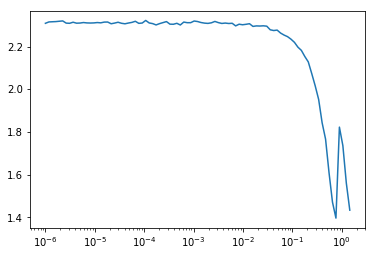

In [59]:
#dont plot the last 5 losses 
run.recorder.plot(skip_last=5)

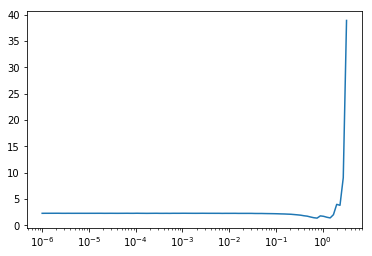

In [60]:
run.recorder.plot()

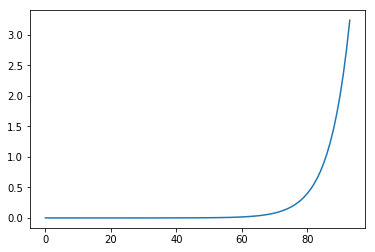

In [61]:
run.recorder.plot_lr()

## Export

In [19]:
#!python notebook2script.py 05b_early_stopping.ipynb